# Verification of melt parameterisation

Use python scipy method, with consistent constants, to check what melt is predicted given ocean model output

There will be some difference due to time averaging - time averaging of forcing variables \neq time average of melt.

Also need to treat Losch layer in MITgcm

Good agreement for both models, indicating I have coded the parameterisations accurately.

In [1]:
#Load required packages
%matplotlib inline
import matplotlib.pyplot as plt
import xarray as xr
from xgcm import Grid
import numpy as np
import pandas as pd
import cftime
import IPython.display
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
import sys, os
import warnings
warnings.simplefilter("ignore")
from dask.distributed import Client

from xhistogram.xarray import histogram
import cmcrameri as cmc

from scipy.optimize import fsolve


In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/41905/status,
Dashboard: /proxy/41905/status,Workers: 7
Total threads: 14,Total memory: 63.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43353,Workers: 7
Dashboard: /proxy/41905/status,Total threads: 14
Started: Just now,Total memory: 63.00 GiB
Comm: tcp://127.0.0.1:34443,Total threads: 2
Dashboard: /proxy/44855/status,Memory: 9.00 GiB
Nanny: tcp://127.0.0.1:33205,


In [3]:
# python param MOM6 version
def solve_three_eqn_python_isomipcoeffs(ustar, depth, sst,
                    sss, J10_Gamma = True, Rosevear_Gamma = False, HJ99_Gamma = False, R22lim = False,
                                       MK18 = False, theta = 10, R22MK18 = False,HJ99_Gamma_M81 =False):
    
    R0 = 1028 #kg/m^3
    Cp = 3974 #J/K/kg
    lam_1 = -0.0573 #Ckg/g (salinity)
    lam_2 = -7.53e-4 #C/dbar (pressure)
    lam_3 = 0.0832 # offset
    L = 3.34e5 #J/kg
    Ri = 1000 #918 #kg/m^3
    g =9.8
    p = depth*R0*g #pascals p = rho*g*h for hydrostatic 
    p = p/1e4 #dbar
    I_VK = 1/0.40
    kv_molec = 1.95e-6
    dR0_dT = -0.0383569483 #[kg m-3 K-1] =alpha*R0
    dR0_dS = 0.805876093   #[kg m-3 PSU-1] =alpha*R0
    dB_dS = g/R0*dR0_dS
    dB_dT = g/R0*dR0_dT
    A =-9.89970135344883 #-9.29# -9.489
    B = 0.22260090020804837 #0.122 #0.155
    C = -7.3904118372660035 #-7.58 #-7.182
    D = 0.32220281249744703 #0.354 #0.290
    Lplus = 0
    Lplus_new = 0
    def func(x):
        Tb,Sb,m = x
        return [Tb -lam_1*Sb-lam_2*p-lam_3,
                m - Cp/L*R0/Ri*Gam_T*ustar*(sst-Tb),
                m + R0/Ri*Gam_S*ustar*(Sb-sss)/Sb]
    def func2(x):
        Tb,Sb,m = x
        return [Tb -lam_1*Sb-lam_2*p-lam_3,
                m - Cp/L*R0/Ri*gamma_T*(sst-Tb),
                m + R0/Ri*gamma_S*(Sb-sss)/Sb] #uses gammaT, gammaS exchange VEL not coeff
    
    if J10_Gamma == True:
        Gam_T = 0.011
        Gam_S = 3.1e-4

        Tb,Sb,m = fsolve(func, [-1,30,-1])
        
    elif R22lim ==True:
        Gam_T = 0.012
        Gam_S = 3.9e-4

        Tb,Sb,m = fsolve(func, [-1,30,-1])
        
    elif Rosevear_Gamma == True:
        tolerance = 1e-4
        Gam_T = 0.012
        Gam_S = 3.9e-4

        Tb,Sb,m = fsolve(func, [-1,30,-1])
        Tb,Sb,m 
        #iterate to get convergent solution
        wB = dB_dS*(Sb-sss)*ustar*Gam_S + dB_dT*(Tb-sst)*ustar*Gam_T
        for i in np.arange(10):
            if (wB<0): #melting
                #print(i)
                Lplus = -ustar**4 * I_VK * 1.0/(kv_molec * wB)

                Gam_T = np.exp(C) * Lplus**(D) 
                Gam_S = np.exp(A) * Lplus**(B) 
                if Gam_T > 0.012:
                    Gam_T = 0.012
                if Gam_S > 3.9e-4:
                    Gam_S = 3.9e-4    
                Tb,Sb,m  = fsolve(func, [-1,30,1])
                wB = dB_dS*(Sb-sss)*ustar*Gam_S + dB_dT*(Tb-sst)*ustar*Gam_T
                Lplus_new = -ustar**4 * I_VK * 1.0/(kv_molec * wB)
                if np.abs(Lplus_new-Lplus) < tolerance:
                    break                    
            else:
                Tb,Sb,m = fsolve(func, [-1,30,1])
                break
                
    elif MK18 == True:
        Gam_T = 0.012
        Gam_S = 3.9e-4
        Tb,Sb,m = fsolve(func, [1,30,1]) # first get a preliminary Tb,Sb with SF Gamma's
        c_1 = 0.086
        kd_molec_salt = 8.02e-10 #m2 s-1
        kd_molec_temp = 1.41e-7 #m2 s-1
        
        for i in np.arange(10):
            gamma_T = c_1*(g*((sss-Sb)*dR0_dS+(sst-Tb)*dR0_dT)*kd_molec_salt**(1/2)/ \
                           (kv_molec*1030))**(1/3)*kd_molec_temp**(1/2)*np.sin(theta*np.pi/180)**(2/3)
            gamma_S = gamma_T*(Ri*Sb)/(R0*sss)*np.sqrt(kd_molec_salt/kd_molec_temp)

            Tb,Sb,m = fsolve(func2, [Tb,Sb,m])
            
    elif R22MK18 == True:
        tolerance = 1e-4
        Gam_T = 0.012
        Gam_S = 3.9e-4
        c_1 = 0.086
        kd_molec_salt = 8.02e-10 #m2 s-1
        kd_molec_temp = 1.41e-7 #m2 s-1

        Tb,Sb,m = fsolve(func, [-1,30,1])
        #iterate to get convergent solution
        wB = dB_dS*(Sb-sss)*ustar*Gam_S + dB_dT*(Tb-sst)*ustar*Gam_T
        for i in np.arange(30):
            if (wB<0): #melting
                #print(i)
                Lplus = -ustar**4 * I_VK * 1.0/(kv_molec * wB)

                Gam_T = np.exp(C) * Lplus**(D) 
                Gam_S = np.exp(A) * Lplus**(B) 
                if Gam_T > 0.012:
                    Gam_T = 0.012
                if Gam_S > 3.9e-4:
                    Gam_S = 3.9e-4    
                    
                #now choose max transfer coeff of R22 and MK18:
                gamma_T = max(Gam_T*ustar, c_1*(g*((sss-Sb)*dR0_dS+(sst-Tb)*dR0_dT)*kd_molec_salt**(1/2)/ \
                           (kv_molec*1030))**(1/3)*kd_molec_temp**(1/2)*np.sin(theta*np.pi/180)**(2/3))
                gamma_S = max(Gam_S*ustar, c_1*(g*((sss-Sb)*dR0_dS+(sst-Tb)*dR0_dT)*kd_molec_salt**(1/2)/ \
                           (kv_molec*1030))**(1/3)*kd_molec_temp**(1/2)*np.sin(theta*np.pi/180)**(2/3)*\
                              (Ri*Sb)/(R0*sss)*np.sqrt(kd_molec_salt/kd_molec_temp))

                Tb,Sb,m = fsolve(func2, [-1,30,1])
                
                wB = dB_dS*(Sb-sss)*gamma_S + dB_dT*(Tb-sst)*ustar*gamma_T
                Lplus_new = -ustar**4 * I_VK * 1.0/(kv_molec * wB)
                if np.abs(Lplus_new-Lplus) < tolerance:
                    break                    
            else:
                Tb,Sb,m = fsolve(func, [-1,30,-1])
                break
                
    elif HJ99_Gamma == True:
        Pr = 7.1
        Sc = 1239
        k = 0.41
        xiN = 0.052
        f = 0.000137
        h = 5*kv_molec/ustar
        eta = 1
        
        gamma_turb = 1/k*np.log(ustar*xiN/f/h*eta**2) + 1/(2*xiN*eta)-1/k
        
        gamma_T = ustar/(gamma_turb+12.5*Pr**(2/3)-6)
        gamma_S = ustar/(gamma_turb+12.5*Sc**(2/3)-6)
        
        Tb,Sb,m = fsolve(func2, [-1,30,1])
        
        Gam_T = gamma_T/ustar
        Gam_S = gamma_S/ustar

    elif HJ99_Gamma_M81 == True:
        gamma_T = 0.011*ustar
        gamma_S = 3.1e-4*ustar

        Tb,Sb,m = fsolve(func2, [-1,30,1]) #initial guess so we can calc buoyancy

        Pr = 7.1
        Sc = 1239
        k = 0.41
        xiN = 0.052
        f = 0.000137
        h = 5*kv_molec/ustar
        Rc = 0.2
        #eta = 1 # intial guess
        
        for i in np.arange(10):
            # iterate to match buoyancy/L/eta* with melt rate, Tb and Sb
            wB = dB_dS*(Sb-sss)*gamma_S + dB_dT*(Tb-sst)*gamma_T
            L_o = -ustar**3/k/wB
            if L_o>0:
                eta = (1 + xiN*ustar/f/Rc/L_o)**(-1/2)
            else:
                eta = 1
        
            gamma_turb = 1/k*np.log(ustar*xiN*eta**2/(f*h)) + 1/(2*xiN*eta)-1/k
        
            gamma_T = ustar/(gamma_turb+12.5*Pr**(2/3)-6)
            gamma_S = ustar/(gamma_turb+12.5*Sc**(2/3)-6)
        
            Tb,Sb,m = fsolve(func2, [-1,30,1])
            
        
        Gam_T = gamma_T/ustar
        Gam_S = gamma_S/ustar

    return Tb,Sb,m*365*3600*24,Gam_T,Gam_S,Lplus #Tb,Sb,m in m/yr

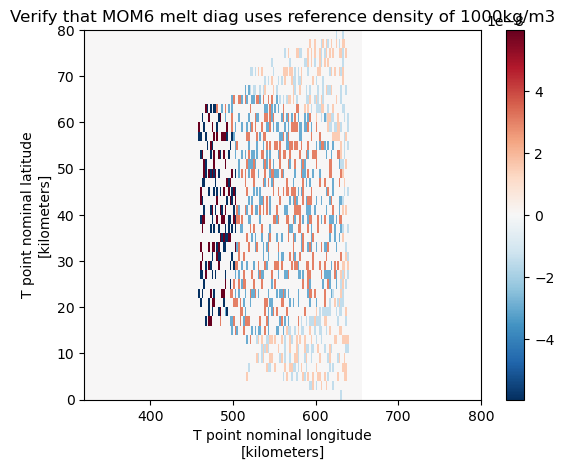

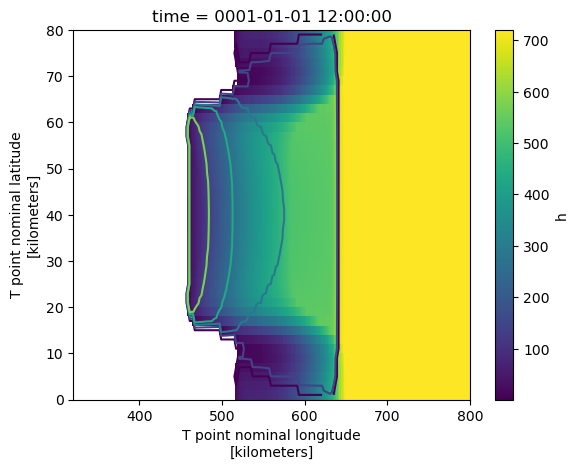

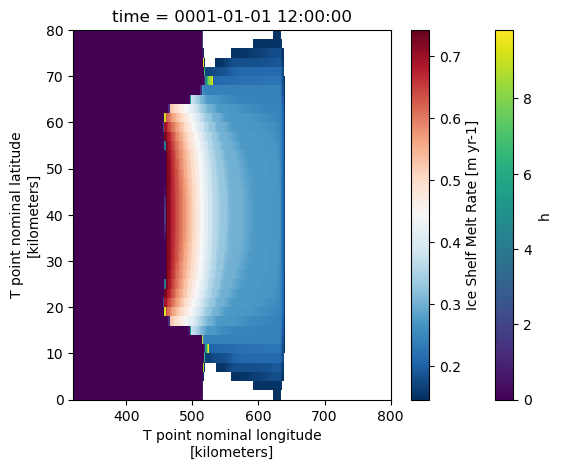

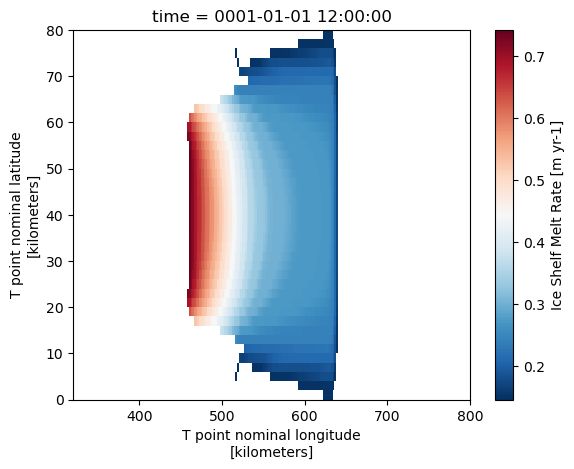

In [10]:
ocean_daily_z = xr.open_dataset('/scratch/x77/cy8964/mom6/archive/layer-thermo-on-warm_SF/output000/ocean_daily_z.nc')

ustar = ocean_daily_z.ustar_shelf.isel(time = 30)
tos = ocean_daily_z.tos.isel(time = 30)
sos = ocean_daily_z.sos.isel(time = 30)
tfreeze = ocean_daily_z.tos.isel(time = 30)
depth = -(ocean_daily_z.zos.isel(time = 30) - np.max(ocean_daily_z.zos.isel(time = 30)))

melt = ocean_daily_z.melt.isel(time = 30)
thermal_driving = ocean_daily_z.thermal_driving.isel(time = 30)
haline_driving = ocean_daily_z.haline_driving.isel(time = 30)
lplus = ocean_daily_z.lplus.isel(time = 30)
mass_flux = ocean_daily_z.mass_flux.isel(time = 30)
area = ocean_daily_z.area_shelf_h.isel(time = 30)

meltrate_conversion = 86400*365/1000
(mass_flux/area*meltrate_conversion-melt).plot()
plt.title('Verify that MOM6 melt diag uses reference density of 1000kg/m3')
plt.show()

ocean_daily_z.h.isel(time = 0).sum('z_l').where(ocean_daily_z.h.isel(time = 0).sum('z_l')>1).plot()
ocean_daily_z.melt.isel(time = 0).plot.contour()
plt.show()
ocean_daily_z.h.isel(time = 0).sum('z_l').where(ocean_daily_z.h.isel(time = 0).sum('z_l')<10).plot()
ocean_daily_z.melt.isel(time = 0).where(ocean_daily_z.melt.isel(time = 0)!=0).plot(cmap = 'RdBu_r')
plt.show()
ocean_daily_z.melt.isel(time = 0).where(ocean_daily_z.melt.isel(time = 0)!=0).plot(cmap = 'RdBu_r')

#melting is set to zero for ocean depth less than 10m


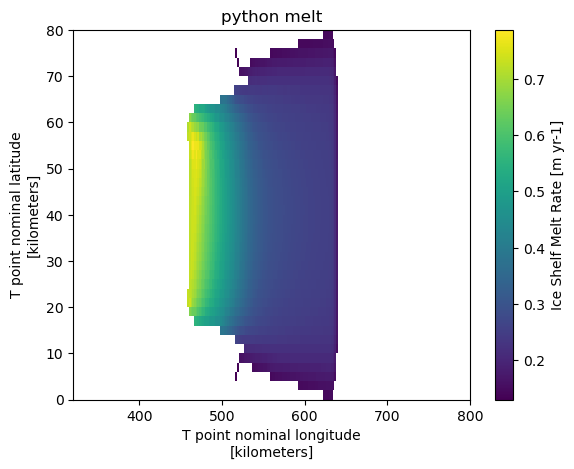

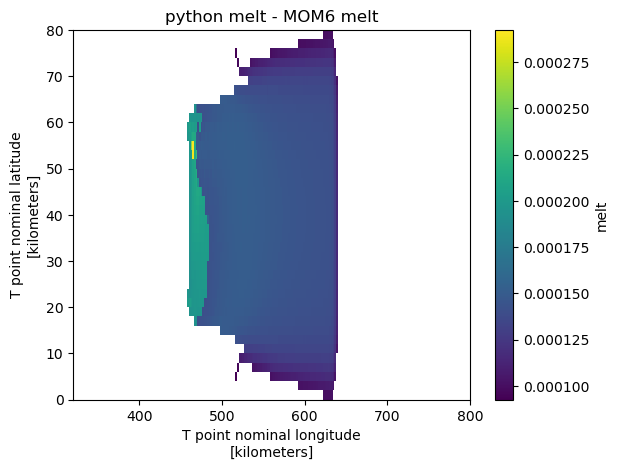

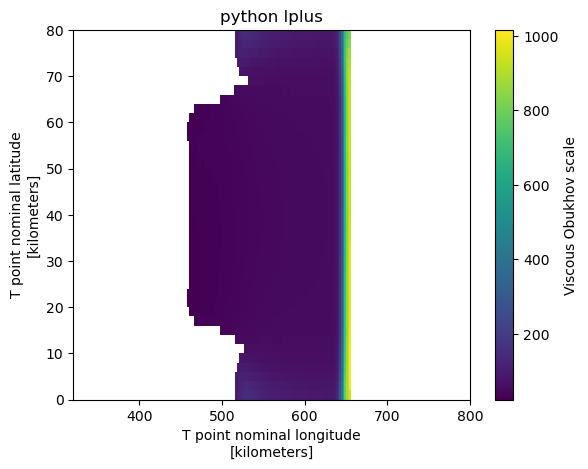

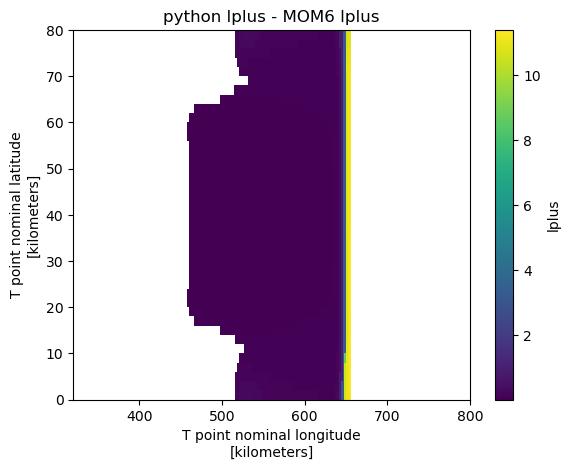

Text(0.5, 1.0, 'ratio python lplus - MOM6 lplus over MOM6 lplus')

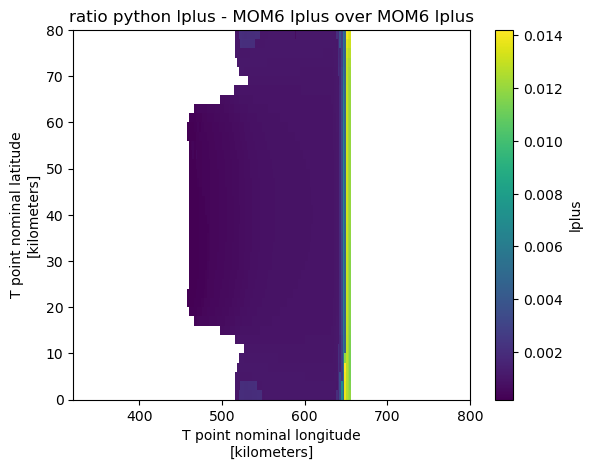

In [8]:
m_arr = xr.zeros_like(melt)
Td_arr = xr.zeros_like(thermal_driving)
Sd_arr = xr.zeros_like(haline_driving)
Lplus_arr = xr.zeros_like(lplus)

for i in np.arange(len(ustar.xT.values)):
    for j in np.arange(len(ustar.yT.values)):
        Tb,Sb,m, Gam_T,Gam_S,Lplus = solve_three_eqn_python_isomipcoeffs(ustar.values[j,i], depth.values[j,i], tos.values[j,i],
                     sos.values[j,i], J10_Gamma = False, Rosevear_Gamma = True, HJ99_Gamma = False, R22lim = False)
        m_arr[j,i] = m
        Td_arr[j,i] = tos.values[j,i] - Tb
        Sd_arr[j,i] = sos.values[j,i] - Sb
        Lplus_arr[j,i] = Lplus

m_arr.where(melt!=0).plot()
plt.title('python melt')
plt.show()
(m_arr.where(melt!=0)-melt).plot()
plt.title('python melt - MOM6 melt')
plt.show()
Lplus_arr.where(lplus!=0).plot()
plt.title('python lplus')
plt.show()
(Lplus_arr.where(lplus!=0)-lplus).plot()
plt.title('python lplus - MOM6 lplus')
plt.show()
((Lplus_arr.where(lplus!=0)-lplus)/lplus).plot()
plt.title('ratio python lplus - MOM6 lplus over MOM6 lplus')


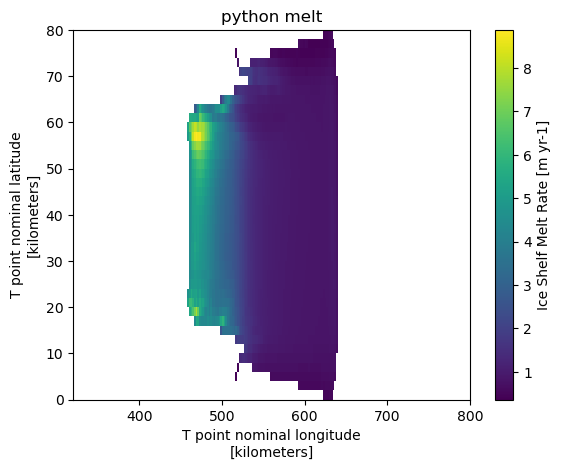

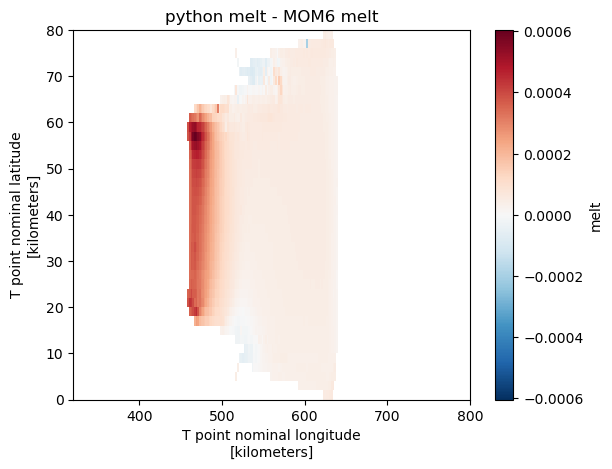

Text(0.5, 1.0, 'Thermal driving difference showing using coean_daily_z is not such a bag choice (real value is BML average)')

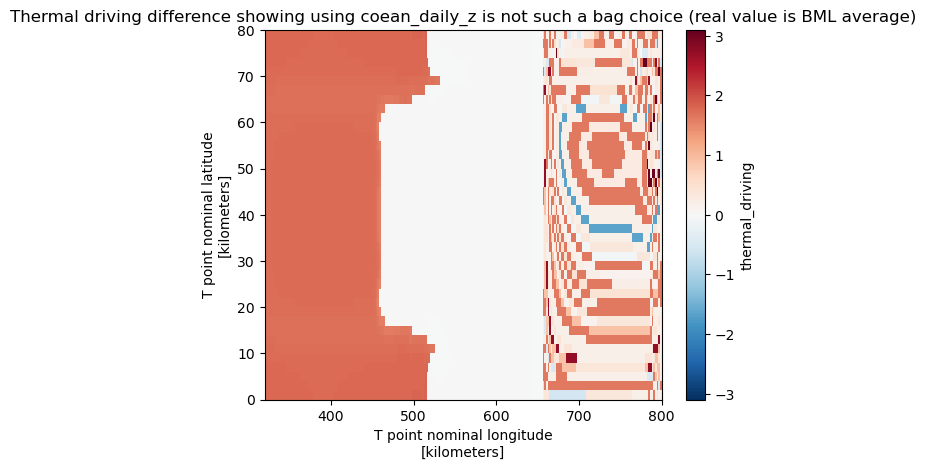

In [9]:
ocean_daily_z = xr.open_dataset('/scratch/x77/cy8964/mom6/archive/layer-thermo-on-warm_CC/output000/ocean_daily_z.nc')
prog = xr.open_dataset('/scratch/x77/cy8964/mom6/archive/layer-thermo-on-warm_CC/output000/prog__0001_002.nc')

ustar = ocean_daily_z.ustar_shelf.isel(time = 30)
tos = ocean_daily_z.tos.isel(time = 30)
sos = ocean_daily_z.sos.isel(time = 30)
tfreeze = ocean_daily_z.tos.isel(time = 30)

# average of BML properties
#tos = (prog.temp.isel(Time = 30,zl = np.arange(2))*prog.h.isel(Time = 30,zl = np.arange(2))).sum('zl')/(prog.h.isel(Time = 30,zl = np.arange(2)).sum('zl'))
#sos = (prog.salt.isel(Time = 30,zl = np.arange(2))*prog.h.isel(Time = 30,zl = np.arange(2))).sum('zl')/(prog.h.isel(Time = 30,zl = np.arange(2)).sum('zl'))


depth = -(ocean_daily_z.zos.isel(time = 30) - np.max(ocean_daily_z.zos.isel(time = 30)))

melt = ocean_daily_z.melt.isel(time = 30)
thermal_driving = ocean_daily_z.thermal_driving.isel(time = 30)
haline_driving = ocean_daily_z.haline_driving.isel(time = 30)
mass_flux = ocean_daily_z.mass_flux.isel(time = 30)
area = ocean_daily_z.area_shelf_h.isel(time = 30)

m_arr = xr.zeros_like(melt)
Td_arr = xr.zeros_like(thermal_driving)
Sd_arr = xr.zeros_like(haline_driving)

for i in np.arange(len(ustar.xT.values)):
    for j in np.arange(len(ustar.yT.values)):
        Tb,Sb,m, Gam_T,Gam_S,Lplus = solve_three_eqn_python_isomipcoeffs(ustar.values[j,i], depth.values[j,i], tos.values[j,i],
                     sos.values[j,i], J10_Gamma = False, Rosevear_Gamma = False, HJ99_Gamma = False, R22lim = True)
        m_arr[j,i] = m
        Td_arr[j,i] = tos.values[j,i] - Tb
        Sd_arr[j,i] = sos.values[j,i] - Sb
m_arr.where(melt!=0).plot()
plt.title('python melt')
plt.show()
(m_arr.where(melt!=0)-melt).plot()
plt.title('python melt - MOM6 melt')
plt.show()
(Td_arr-thermal_driving).plot()
plt.title('Thermal driving difference showing using coean_daily_z is not such a bag choice (real value is BML average)')

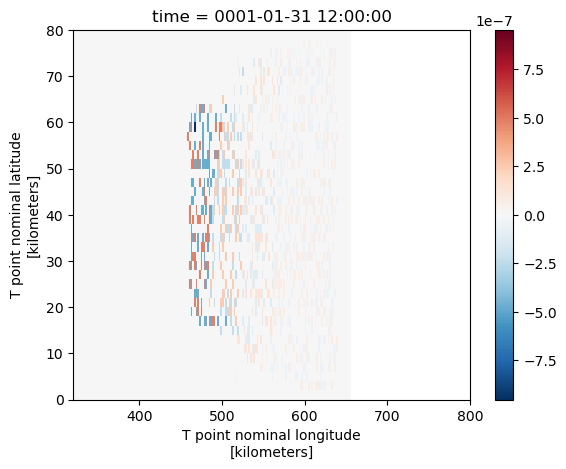

In [10]:
meltrate_conversion = 86400*365/1000
(mass_flux/area*meltrate_conversion-melt).plot()

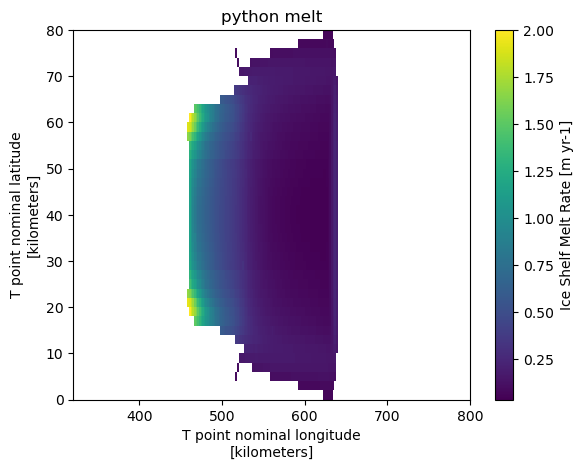

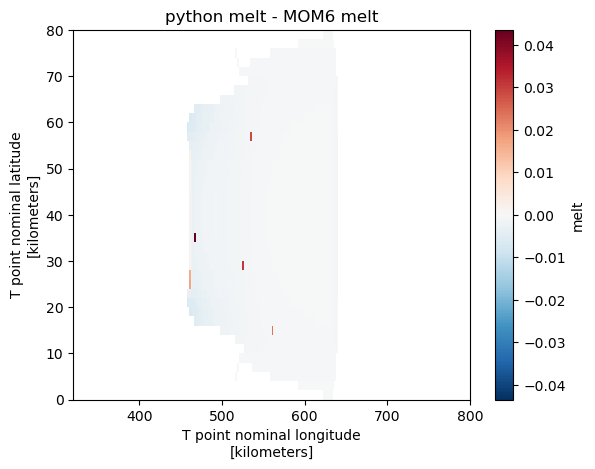

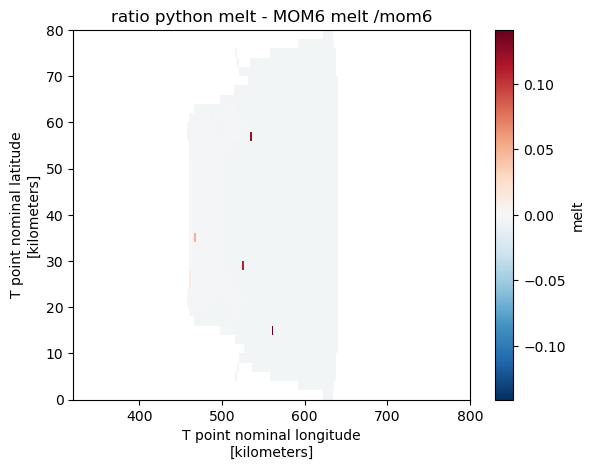

In [15]:
ocean_daily_z = xr.open_dataset('/scratch/x77/cy8964/mom6/archive/layer-thermo-on-warm_SF-MK18test/output000/ocean_daily_z.nc')

ustar = ocean_daily_z.ustar_shelf.isel(time = 10)
tos = ocean_daily_z.tos.isel(time = 10)
sos = ocean_daily_z.sos.isel(time = 10)
tfreeze = ocean_daily_z.tos.isel(time = 10)
depth = -(ocean_daily_z.zos.isel(time = 10) - np.max(ocean_daily_z.zos.isel(time = 10)))
ice_base_angle = ocean_daily_z.ice_base_angle.isel(time = 10)

melt = ocean_daily_z.melt.isel(time = 10)
thermal_driving = ocean_daily_z.thermal_driving.isel(time = 10)
haline_driving = ocean_daily_z.haline_driving.isel(time = 10)
lplus = ocean_daily_z.lplus.isel(time = 10)
mass_flux = ocean_daily_z.mass_flux.isel(time = 10)
area = ocean_daily_z.area_shelf_h.isel(time = 10)

m_arr = xr.zeros_like(melt)
Td_arr = xr.zeros_like(thermal_driving)
Sd_arr = xr.zeros_like(haline_driving)
Lplus_arr = xr.zeros_like(lplus)

for i in np.arange(len(ustar.xT.values)):
    for j in np.arange(len(ustar.yT.values)):
        Tb,Sb,m, Gam_T,Gam_S,Lplus = solve_three_eqn_python_isomipcoeffs(ustar.values[j,i], depth.values[j,i], tos.values[j,i],
                     sos.values[j,i], theta = ice_base_angle.values[j,i],J10_Gamma = False, R22MK18 = True)
        m_arr[j,i] = m
        Td_arr[j,i] = tos.values[j,i] - Tb
        Sd_arr[j,i] = sos.values[j,i] - Sb
        Lplus_arr[j,i] = Lplus

m_arr.where(melt!=0).plot()
plt.title('python melt')
plt.show()
(m_arr.where(melt!=0)-melt).plot()
plt.title('python melt - MOM6 melt')
plt.show()
((m_arr.where(melt!=0)-melt)/melt).plot()
plt.title('ratio python melt - MOM6 melt /mom6')
plt.show()

In [42]:
ocean_daily_z = xr.open_dataset('/scratch/x77/cy8964/mom6/archive/layer-thermo-on-warm_SF-MK18test/output000/ocean_daily_z.nc')
print(ocean_daily_z.melt.isel(time = -1).mean().values)
ocean_daily_z = xr.open_dataset('/scratch/x77/cy8964/mom6/archive/layer-thermo-on-warm_SF-MK18/output000/ocean_daily_z.nc')
print(ocean_daily_z.melt.isel(time = -1).mean().values)


0.08484587
0.08881246


# Try MITgcm

In [158]:
# python param
def solve_three_eqn_python_isomipcoeffs(ustar, depth, sst,
                    sss, J10_Gamma = True, Rosevear_Gamma = False, HJ99_Gamma = False, R22lim = False):
    
    R0 = 1027.21 #kg/m^3
    Cp = 3974 #J/K/kg
    lam_1 = -0.0573 #Ckg/g (salinity)
    lam_2 = -7.53e-4 #C/dbar (pressure)
    lam_3 = 0.0832 # offset
    L = 3.34e5 #J/kg
    Ri = 1000 #918 #kg/m^3
    g =9.81
    p = depth*R0*g #pascals p = rho*g*h for hydrostatic 
    p = p/1e4 #dbar
    I_VK = 1/0.40
    kv_molec = 1.95e-6
    dR0_dT = -0.0383569483 #[kg m-3 K-1] =alpha*R0
    dR0_dS = 0.805876093   #[kg m-3 PSU-1] =alpha*R0
    dB_dS = g*7.843E-4#*1000/1028 #g/R0*dR0_dS
    dB_dT = -g*3.733E-5#*1000/1028#/R0*dR0_dT
    A =-9.89970135344883 #-9.29# -9.489
    B = 0.22260090020804837 #0.122 #0.155
    C = -7.3904118372660035 #-7.58 #-7.182
    D = 0.32220281249744703 #0.354 #0.290
    Lplus = 0
    def func(x):
        Tb,Sb,m = x
        return [Tb -lam_1*Sb-lam_2*p-lam_3,
                m - Cp/L*R0/Ri*Gam_T*ustar*(sst-Tb),
                m + R0/Ri*Gam_S*ustar*(Sb-sss)/Sb]
    
    if J10_Gamma == True:
        Gam_T = 0.011
        Gam_S = 3.1e-4

        root = fsolve(func, [-1,30,-1])
        Tb,Sb,m = root
        
    elif R22lim ==True:
        Gam_T = 0.012
        Gam_S = 3.9e-4

        root = fsolve(func, [-1,30,-1])
        Tb,Sb,m = root
        
    elif Rosevear_Gamma == True:
        tolerance = 1e-4
        Gam_T = 0.012
        Gam_S = 3.9e-4

        root = fsolve(func, [-1,30,1/(365*3600*24)])
        Tb,Sb,m = root
        #iterate to get convergent solution
        wB = dB_dS*(Sb-sss)*ustar*Gam_S + dB_dT*(Tb-sst)*ustar*Gam_T
        for i in np.arange(10):
            if (wB<0): #melting
                #print(i)
                Lplus = -ustar**4 * I_VK * 1.0/(kv_molec * wB)
                #print(Lplus)

                Gam_T = np.exp(C) * Lplus**(D) 
                Gam_S = np.exp(A) * Lplus**(B) 
                if Gam_T > 0.012:
                    Gam_T = 0.012
                if Gam_S > 3.9e-4:
                    Gam_S = 3.9e-4    
                root = fsolve(func, [-1,30,1/(365*3600*24)])
                Tb,Sb,m = root
                wB = dB_dS*(Sb-sss)*ustar*Gam_S + dB_dT*(Tb-sst)*ustar*Gam_T
                #print(wB)
                Lplus_new = -ustar**4 * I_VK * 1.0/(kv_molec * wB)
                if np.abs(Lplus_new-Lplus) < tolerance:
                    break                    
            else:
                root = fsolve(func, [-1,30,1/(365*3600*24)])
                break
            
    return  Tb,Sb,m*365*3600*24,Gam_T,Gam_S,Lplus#,wB #Tb,Sb,m in m/yr



In [159]:
A =-9.89970135344883 #-9.29# -9.489
B = 0.22260090020804837 #0.122 #0.155
C = -7.3904118372660035 #-7.58 #-7.182
D = 0.32220281249744703 #0.354 #0.290


In [160]:
ustar = 10E-4
depth = 500
sss = 34
sst = -1

Tb,Sb,m,GamT,GamS,Lplus = solve_three_eqn_python_isomipcoeffs(ustar, depth, sst,
                    sss, J10_Gamma = False, Rosevear_Gamma = True, HJ99_Gamma = False, R22lim = False)

wB = g*7.843E-4*(Sb-sss)*ustar*GamS -g*3.733E-5*(Tb-sst)*ustar*GamT
print(wB)
Lpluscheck = -ustar**4 / (0.41 * 1.95E-6 * wB)
print(Lpluscheck)
print(Lplus)
print(np.exp(A) * Lplus**(B) )
print(np.exp(A) * Lpluscheck**(B) )
print(GamS)

#verify code self-consistent

-6.574504199189005e-09
190.24731001630613
195.00658441512067
0.0001623234856642228
0.00016143313664697918
0.0001623234856642228


In [17]:
base_folder_MIT = '/scratch/x77/cy8964/gadi_short/cy8964/mitgcm/archive/'
list_folders_MIT = ['run-J10-warm-utide','run-R22-warm-utide', 
                'run-J10-cold-utide','run-R22-cold-utide']
no_configs_MIT = len(list_folders_MIT)

# def open_files_MIT(i):
#     folder = base_folder_MIT+list_folders_MIT[i]+'/output001/'
#     folder1 = base_folder_MIT+list_folders_MIT[i]+'/output000/'
    
#     grid = xr.open_dataset(folder1 + 'grid.nc')    
#     tave = xr.open_dataset(folder + 'tave.nc')
#     shelficetave = xr.open_dataset(folder + 'shelfice_tave.nc')
#     shelfsnap = xr.open_dataset(folder + 'shelfsnap.nc')
#     return grid, tave, shelficetave, shelfsnap
def open_files_MIT(i):
    folder = base_folder_MIT+list_folders_MIT[i]+'/output000/'
    folder1 = base_folder_MIT+list_folders_MIT[i]+'/output000/'
    
    grid = xr.open_dataset(folder1 + 'grid.nc')    
    tave = xr.open_dataset(folder + 'tave.nc')
    shelficetave = xr.open_dataset(folder + 'shelfice_tave.nc')
    shelfsnap = xr.open_dataset(folder + 'shelfsnap.nc')
    return grid, tave, shelficetave, shelfsnap

# melt in kg/m^2/s to m/yr = multiply by #seconds per year, divide by rho_0
s_to_yr = 365*24*3600
rho0 = 1030 #should be 1000!

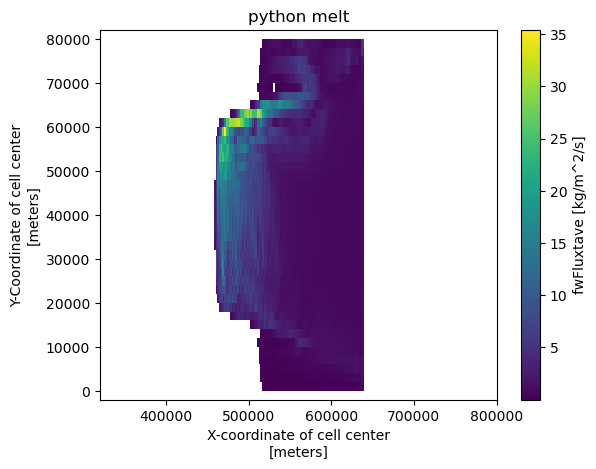

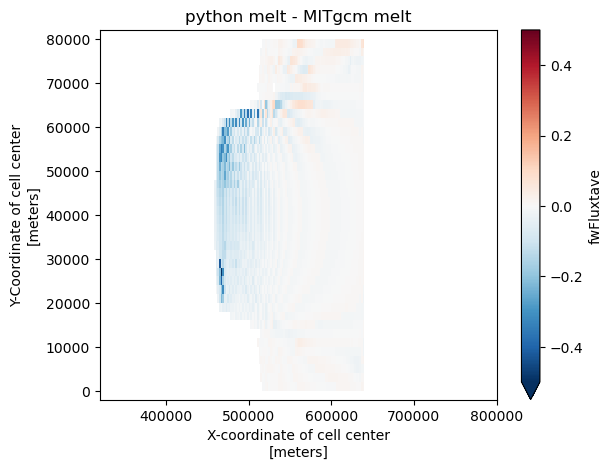

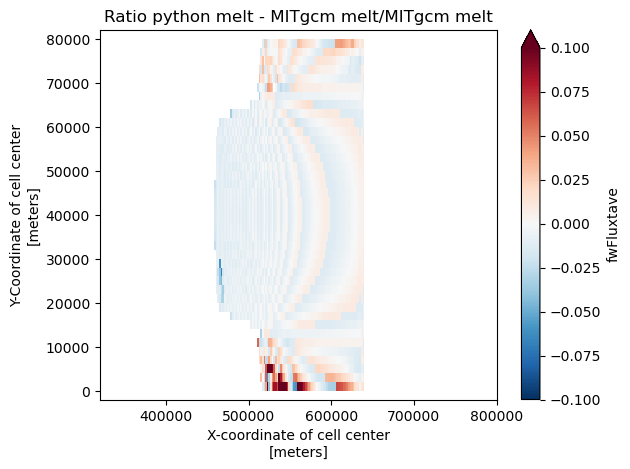

In [162]:
grid, tave, shelficetave, shelfsnap = open_files_MIT(0)
t = tave.Ttave.isel(T = 30)
s = tave.Stave.isel(T = 30)
ustar = shelfsnap.SHIuStar.isel(T = 30)[0,...]
Lplus = shelfsnap.SHILplus.isel(T = 30)
melt = shelficetave.fwFluxtave.isel(T = 30)

highest_cell = (t.where(t!=0)+(t.Z)).max('Z',skipna = True)
partial_cell_size = grid.HFacC.where(t.Z > highest_cell).where(grid.HFacC > 0)
Losch_thick = np.minimum(grid.HFacC.where(t.Z > highest_cell-20).where(grid.HFacC > 0).sum('Z'),np.ones_like(grid.HFacC.where(t.Z > highest_cell-20).where(grid.HFacC > 0).sum('Z')))
difference = Losch_thick - partial_cell_size.sum('Z')

tsurf = t.where(t.Z > highest_cell).where(t!=0).sum('Z')
tos = ((t.where(t.Z > highest_cell).where(t!=0)*partial_cell_size).sum('Z') + \
    ((difference)*t.where(t.Z >= highest_cell-20).where(t.Z < highest_cell)).sum('Z') )/Losch_thick#Losch Layer

ssurf = s.where(s.Z > highest_cell).where(s!=0).sum('Z')
sos = ((s.where(s.Z > highest_cell).where(s!=0)*partial_cell_size).sum('Z') + \
    ((difference)*s.where(s.Z > highest_cell-20).where(s.Z < highest_cell)).sum('Z') )/Losch_thick#Losch Layer

m_arr = xr.zeros_like(melt)
Td_arr = xr.zeros_like(melt)
Sd_arr = xr.zeros_like(melt)

for i in np.arange(len(ustar.X.values)):
    for j in np.arange(len(ustar.Y.values)):
        Tb,Sb,m, Gam_T,Gam_S,Lplus = solve_three_eqn_python_isomipcoeffs(ustar.values[j,i], -highest_cell.values[j,i], tos.values[j,i],
                     sos.values[j,i], J10_Gamma = False, Rosevear_Gamma = False, HJ99_Gamma = False, R22lim = True)
        m_arr[j,i] = m
        Td_arr[j,i] = tos.values[j,i] - Tb
        Sd_arr[j,i] = sos.values[j,i] - Sb

m_arr.where(melt!=0).plot()
plt.title('python melt')
plt.show()
(melt*86400*365/1000+m_arr.where(melt!=0)).plot(vmax = 0.5, vmin = -0.5, cmap = 'RdBu_r')
plt.title('python melt - MITgcm melt')
plt.show()
((melt*86400*365/1000+m_arr.where(melt!=0))/melt/(-1*86400*365/1000)).plot(vmax = 0.1)
plt.title('Ratio python melt - MITgcm melt/MITgcm melt')
plt.show()


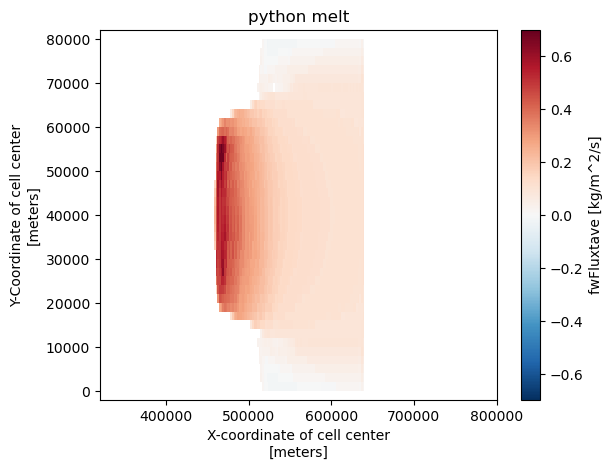

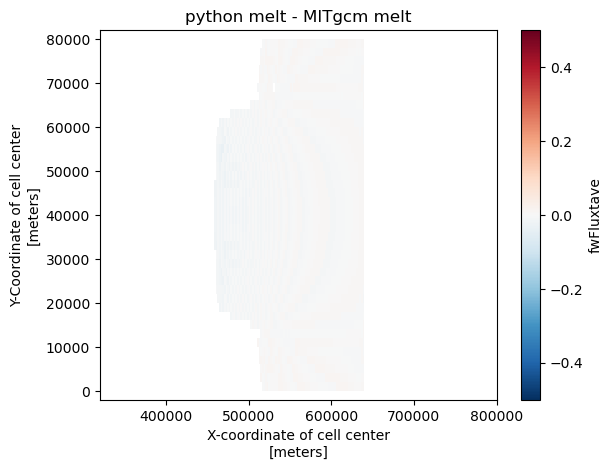

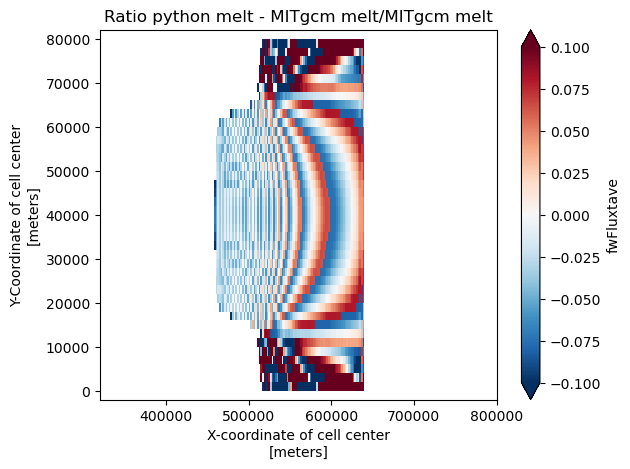

In [163]:
grid, tave, shelficetave, shelfsnap = open_files_MIT(2)
t = tave.Ttave.isel(T = 30)
s = tave.Stave.isel(T = 30)
ustar = shelfsnap.SHIuStar.isel(T = 30)[0,...]
Lplus = shelfsnap.SHILplus.isel(T = 30)
melt = shelficetave.fwFluxtave.isel(T = 30)

highest_cell = (t.where(t!=0)+(t.Z)).max('Z',skipna = True)
partial_cell_size = grid.HFacC.where(t.Z > highest_cell).where(grid.HFacC > 0)
Losch_thick = np.minimum(grid.HFacC.where(t.Z > highest_cell-20).where(grid.HFacC > 0).sum('Z'),np.ones_like(grid.HFacC.where(t.Z > highest_cell-20).where(grid.HFacC > 0).sum('Z')))
difference = Losch_thick - partial_cell_size.sum('Z')

tsurf = t.where(t.Z > highest_cell).where(t!=0).sum('Z')
tos = ((t.where(t.Z > highest_cell).where(t!=0)*partial_cell_size).sum('Z') + \
    ((difference)*t.where(t.Z >= highest_cell-20).where(t.Z < highest_cell)).sum('Z') )/Losch_thick#Losch Layer

ssurf = s.where(s.Z > highest_cell).where(s!=0).sum('Z')
sos = ((s.where(s.Z > highest_cell).where(s!=0)*partial_cell_size).sum('Z') + \
    ((difference)*s.where(s.Z > highest_cell-20).where(s.Z < highest_cell)).sum('Z') )/Losch_thick#Losch Layer



m_arr = xr.zeros_like(melt)
Td_arr = xr.zeros_like(melt)
Sd_arr = xr.zeros_like(melt)

for i in np.arange(len(ustar.X.values)):
    for j in np.arange(len(ustar.Y.values)):
        Tb,Sb,m, Gam_T,Gam_S,Lplus = solve_three_eqn_python_isomipcoeffs(ustar.values[j,i], -highest_cell.values[j,i], tos.values[j,i],
                     sos.values[j,i], J10_Gamma = False, Rosevear_Gamma = False, HJ99_Gamma = False, R22lim = True)
        m_arr[j,i] = m
        Td_arr[j,i] = tos.values[j,i] - Tb
        Sd_arr[j,i] = sos.values[j,i] - Sb

m_arr.where(melt!=0).plot()
plt.title('python melt')
plt.show()
(melt*86400*365/1000+m_arr.where(melt!=0)).plot(vmax = 0.5, vmin = -0.5, cmap = 'RdBu_r')
plt.title('python melt - MITgcm melt')
plt.show()
((melt*86400*365/1000+m_arr.where(melt!=0))/melt/(-1*86400*365/1000)).plot(vmax = 0.1)
plt.title('Ratio python melt - MITgcm melt/MITgcm melt')
plt.show()


In [164]:
s.Z.values

array([ -10.,  -30.,  -50.,  -70.,  -90., -110., -130., -150., -170.,
       -190., -210., -230., -250., -270., -290., -310., -330., -350.,
       -370., -390., -410., -430., -450., -470., -490., -510., -530.,
       -550., -570., -590., -610., -630., -650., -670., -690., -710.,
       -730.])

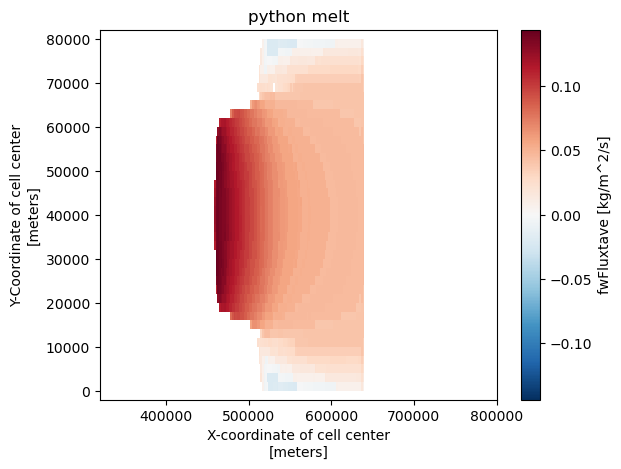

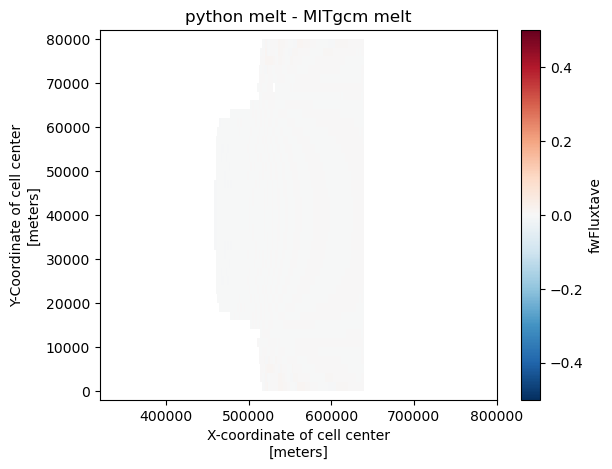

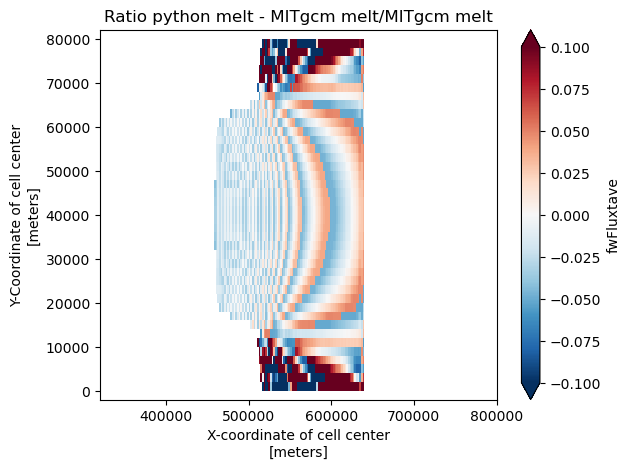

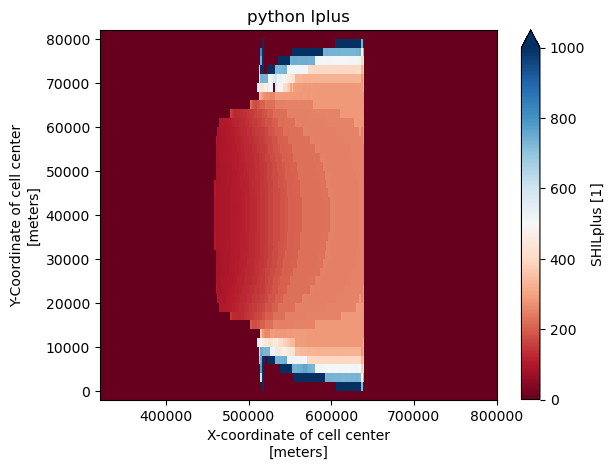

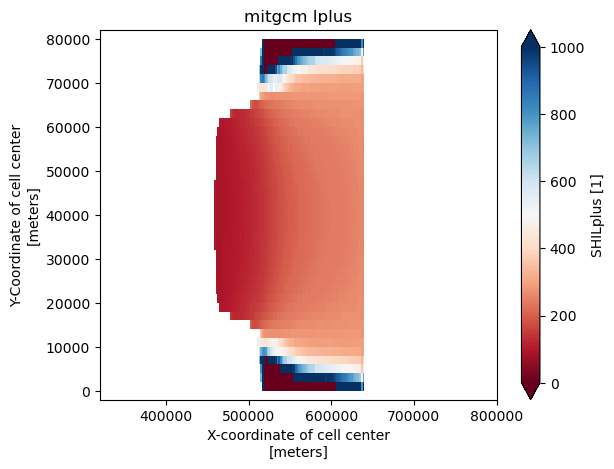

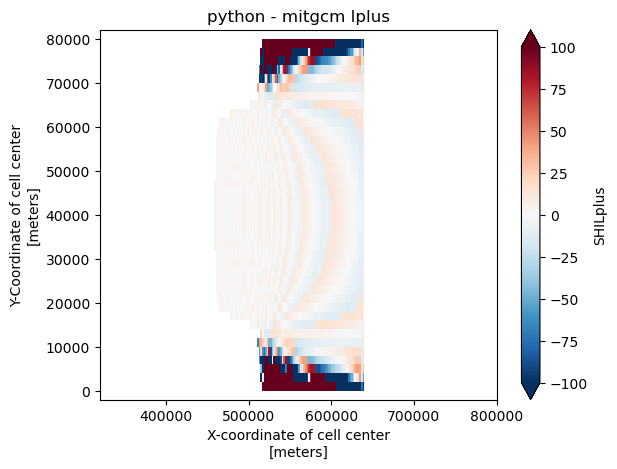

Text(0.5, 1.0, 'ratio python - mitgcm lplus /mitgcm lplus')

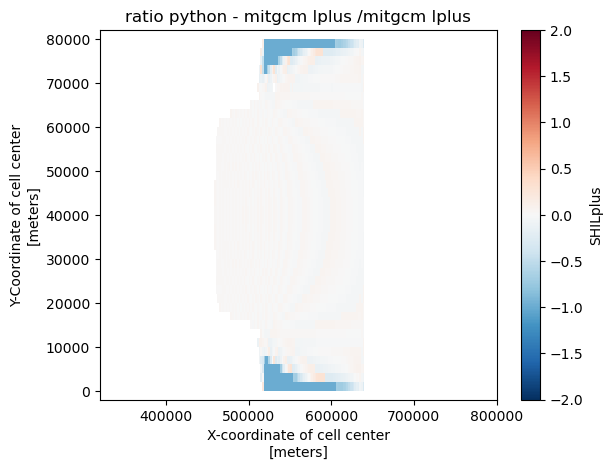

In [165]:
grid, tave, shelficetave, shelfsnap = open_files_MIT(3)
t = tave.Ttave.isel(T = 30)
s = tave.Stave.isel(T = 30)
ustar = shelfsnap.SHIuStar.isel(T = 30)[0,...]
lplus = shelfsnap.SHILplus.isel(T = 30)[0,...]
melt = shelficetave.fwFluxtave.isel(T = 30)

highest_cell = (t.where(t!=0)+(t.Z)).max('Z',skipna = True)
partial_cell_size = grid.HFacC.where(t.Z > highest_cell).where(grid.HFacC > 0)
Losch_thick = np.minimum(grid.HFacC.where(t.Z > highest_cell-20).where(grid.HFacC > 0).sum('Z'),np.ones_like(grid.HFacC.where(t.Z > highest_cell-20).where(grid.HFacC > 0).sum('Z')))
difference = Losch_thick - partial_cell_size.sum('Z')

tsurf = t.where(t.Z > highest_cell).where(t!=0).sum('Z')
tos = ((t.where(t.Z > highest_cell).where(t!=0)*partial_cell_size).sum('Z') + \
    ((difference)*t.where(t.Z >= highest_cell-20).where(t.Z < highest_cell)).sum('Z') )/Losch_thick#Losch Layer

ssurf = s.where(s.Z > highest_cell).where(s!=0).sum('Z')
sos = ((s.where(s.Z > highest_cell).where(s!=0)*partial_cell_size).sum('Z') + \
    ((difference)*s.where(s.Z > highest_cell-20).where(s.Z < highest_cell)).sum('Z') )/Losch_thick#Losch Layer

m_arr = xr.zeros_like(melt)
Td_arr = xr.zeros_like(melt)
Sd_arr = xr.zeros_like(melt)
Lplus_arr = xr.zeros_like(lplus)

for i in np.arange(len(ustar.X.values)):
    for j in np.arange(len(ustar.Y.values)):
        Tb,Sb,m, Gam_T,Gam_S,Lplus = solve_three_eqn_python_isomipcoeffs(ustar.values[j,i], -highest_cell.values[j,i], tos.values[j,i],
                     sos.values[j,i], J10_Gamma = False, Rosevear_Gamma = True, HJ99_Gamma = False, R22lim = False)
        m_arr[j,i] = m
        Td_arr[j,i] = tos.values[j,i] - Tb
        Sd_arr[j,i] = sos.values[j,i] - Sb
        Lplus_arr[j,i] = Lplus

m_arr.where(melt!=0).plot()
plt.title('python melt')
plt.show()
(melt*86400*365/1000+m_arr.where(melt!=0)).plot(vmax = 0.5, vmin = -0.5, cmap = 'RdBu_r')
plt.title('python melt - MITgcm melt')
plt.show()
((melt*86400*365/1000+m_arr.where(melt!=0))/melt/(-1*86400*365/1000)).plot(vmax = 0.1)
plt.title('Ratio python melt - MITgcm melt/MITgcm melt')
plt.show()
Lplus_arr.where(lplus!=0).plot(vmax = 1000, cmap = 'RdBu', vmin = 0)
plt.title('python lplus')
plt.show()
lplus.plot(vmax = 1000, cmap = 'RdBu', vmin = 0)
plt.title('mitgcm lplus')
plt.show()
(Lplus_arr.where(lplus!=0)-lplus).plot(vmax = 100)
plt.title('python - mitgcm lplus')
plt.show()
((Lplus_arr.where(lplus!=0)-lplus)/lplus).plot(vmax = 2)
plt.title('ratio python - mitgcm lplus /mitgcm lplus')


MITgcm turns potential temperature into in situ temp??

Something wrong with my Losch layer - maybe only two layers thick. -> FIXED

MITgcm Lplus and SF melt rates are ~20% too small. Work this out with print statements?? -> MISTAKE IN MY CODE. DENSITY EXPANSION/CONTRQCTION WERE SWAPPED!!

Could Lplus iteration not be converged? I use midpoint of old and new Lplus to iterate -> DEFINITELY CONVERGED

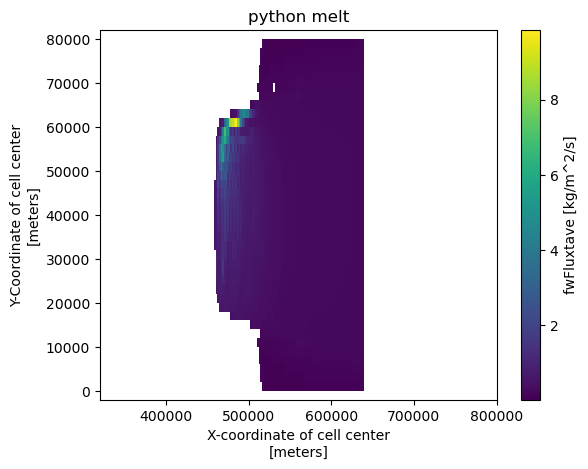

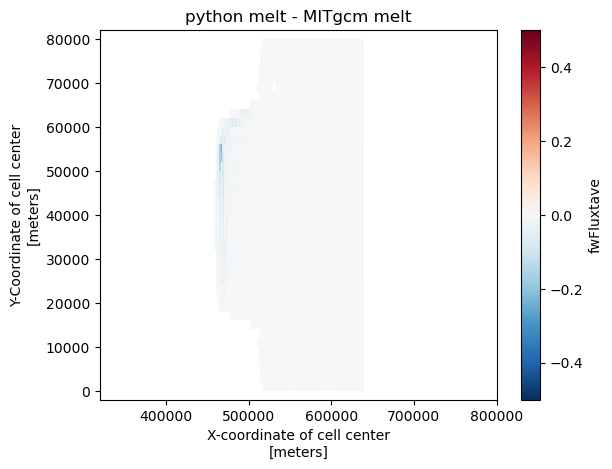

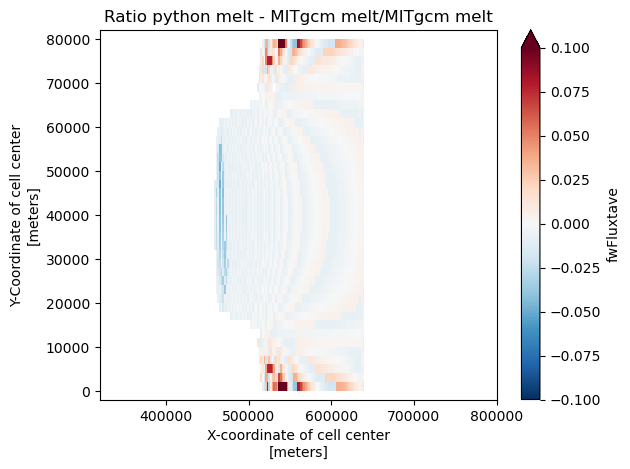

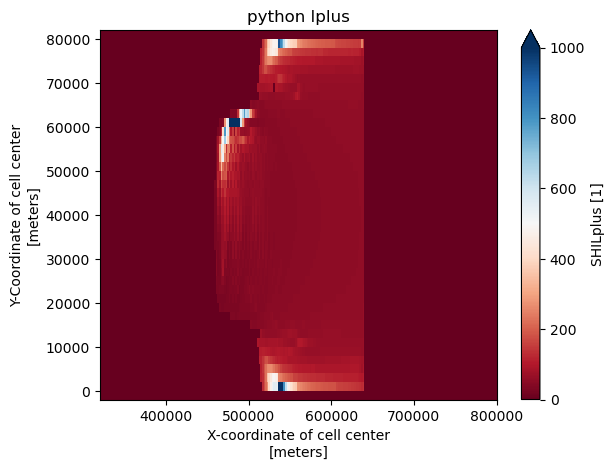

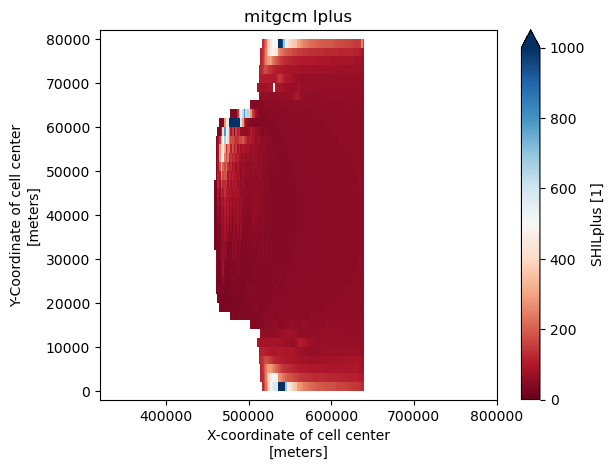

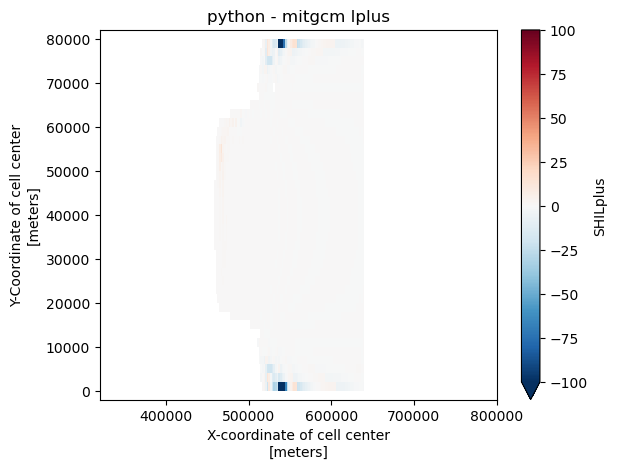

Text(0.5, 1.0, 'ratio python - mitgcm lplus /mitgcm lplus')

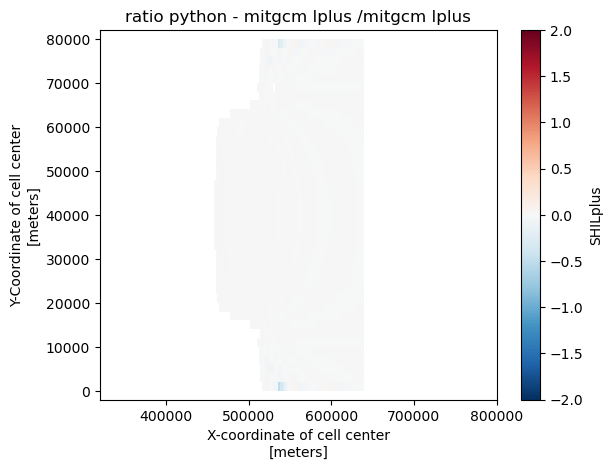

In [166]:
grid, tave, shelficetave, shelfsnap = open_files_MIT(1)
t = tave.Ttave.isel(T = 30)
s = tave.Stave.isel(T = 30)
ustar = shelfsnap.SHIuStar.isel(T = 30)[0,...]
lplus = shelfsnap.SHILplus.isel(T = 30)[0,...]
melt = shelficetave.fwFluxtave.isel(T = 30)

highest_cell = (t.where(t!=0)+(t.Z)).max('Z',skipna = True)
partial_cell_size = grid.HFacC.where(t.Z > highest_cell).where(grid.HFacC > 0)
Losch_thick = np.minimum(grid.HFacC.where(t.Z > highest_cell-20).where(grid.HFacC > 0).sum('Z'),np.ones_like(grid.HFacC.where(t.Z > highest_cell-20).where(grid.HFacC > 0).sum('Z')))
difference = Losch_thick - partial_cell_size.sum('Z')

tsurf = t.where(t.Z > highest_cell).where(t!=0).sum('Z')
tos = ((t.where(t.Z > highest_cell).where(t!=0)*partial_cell_size).sum('Z') + \
    ((difference)*t.where(t.Z >= highest_cell-20).where(t.Z < highest_cell)).sum('Z') )/Losch_thick#Losch Layer

ssurf = s.where(s.Z > highest_cell).where(s!=0).sum('Z')
sos = ((s.where(s.Z > highest_cell).where(s!=0)*partial_cell_size).sum('Z') + \
    ((difference)*s.where(s.Z > highest_cell-20).where(s.Z < highest_cell)).sum('Z') )/Losch_thick#Losch Layer

m_arr = xr.zeros_like(melt)
Td_arr = xr.zeros_like(melt)
Sd_arr = xr.zeros_like(melt)
Lplus_arr = xr.zeros_like(lplus)

for i in np.arange(len(ustar.X.values)):
    for j in np.arange(len(ustar.Y.values)):
        Tb,Sb,m, Gam_T,Gam_S,Lplus = solve_three_eqn_python_isomipcoeffs(ustar.values[j,i], -highest_cell.values[j,i], tos.values[j,i],#-0.1*highest_cell.values[j,i]/1000,
                     sos.values[j,i], J10_Gamma = False, Rosevear_Gamma = True, HJ99_Gamma = False, R22lim = False)
        m_arr[j,i] = m
        Td_arr[j,i] = tos.values[j,i] - Tb
        Sd_arr[j,i] = sos.values[j,i] - Sb
        Lplus_arr[j,i] = Lplus

m_arr.where(melt!=0).plot()
plt.title('python melt')
plt.show()
(melt*86400*365/1000+m_arr.where(melt!=0)).plot(vmax = 0.5, vmin = -0.5, cmap = 'RdBu_r')
plt.title('python melt - MITgcm melt')
plt.show()
((melt*86400*365/1000+m_arr.where(melt!=0))/melt/(-1*86400*365/1000)).plot(vmax = 0.1)
plt.title('Ratio python melt - MITgcm melt/MITgcm melt')
plt.show()
Lplus_arr.where(lplus!=0).plot(vmax = 1000, cmap = 'RdBu', vmin = 0)
plt.title('python lplus')
plt.show()
lplus.plot(vmax = 1000, cmap = 'RdBu', vmin = 0)
plt.title('mitgcm lplus')
plt.show()
(Lplus_arr.where(lplus!=0)-lplus).plot(vmax = 100)
plt.title('python - mitgcm lplus')
plt.show()
((Lplus_arr.where(lplus!=0)-lplus)/lplus).plot(vmax = 2)
plt.title('ratio python - mitgcm lplus /mitgcm lplus')


In [22]:
ice_base_angle.values.shape

(40, 240)

In [41]:
list_folders_MIT = ['run-R22-warm-convectivelimitlocal','run-R22-warm-convectivelimitlocal-testing']

grid, tave, shelficetave, shelfsnap = open_files_MIT(0)
print(shelficetave.fwFluxtave.isel(T = 30).mean().values)
grid, tave, shelficetave, shelfsnap = open_files_MIT(1)
print(shelficetave.fwFluxtave.isel(T = 30).mean().values)



-6.9304538e-06
-7.140781e-06


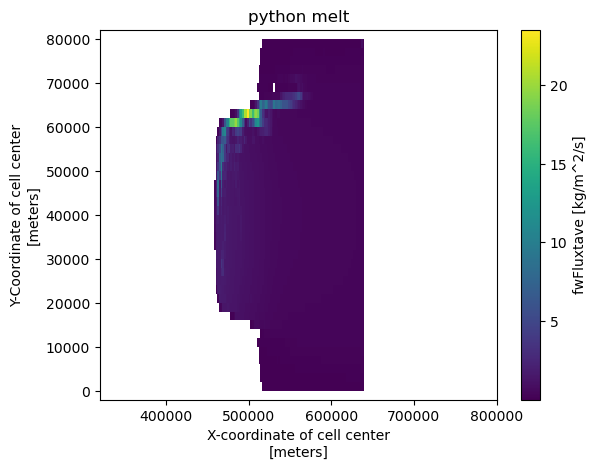

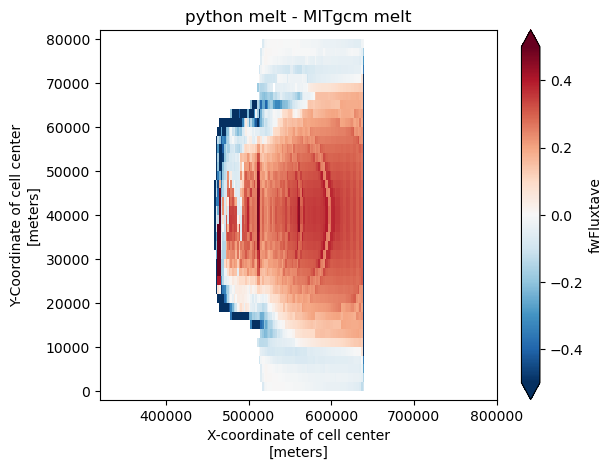

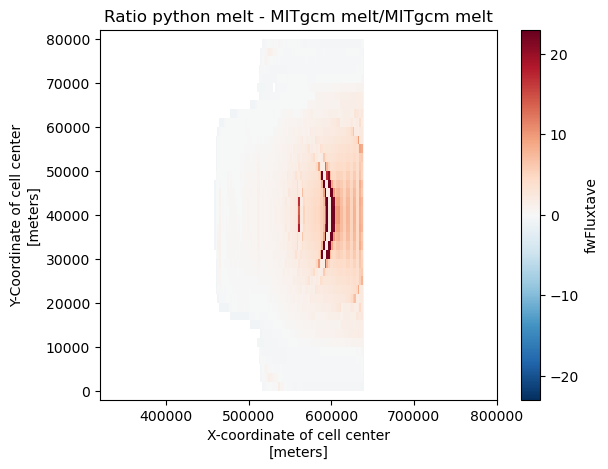

In [39]:
list_folders_MIT = ['run-R22-warm-convectivelimitlocal','run-R22-warm-convectivelimitlocal-testing']

grid, tave, shelficetave, shelfsnap = open_files_MIT(1)
t = tave.Ttave.isel(T = 30)
s = tave.Stave.isel(T = 30)
ustar = shelfsnap.SHIuStar.isel(T = 30)[0,...]
lplus = shelfsnap.SHILplus.isel(T = 30)[0,...]
melt = shelficetave.fwFluxtave.isel(T = 30)

highest_cell = (t.where(t!=0)+(t.Z)).max('Z',skipna = True)
partial_cell_size = grid.HFacC.where(t.Z > highest_cell).where(grid.HFacC > 0)
Losch_thick = np.minimum(grid.HFacC.where(t.Z > highest_cell-20).where(grid.HFacC > 0).sum('Z'),np.ones_like(grid.HFacC.where(t.Z > highest_cell-20).where(grid.HFacC > 0).sum('Z')))
difference = Losch_thick - partial_cell_size.sum('Z')

tsurf = t.where(t.Z > highest_cell).where(t!=0).sum('Z')
tos = ((t.where(t.Z > highest_cell).where(t!=0)*partial_cell_size).sum('Z') + \
    ((difference)*t.where(t.Z >= highest_cell-20).where(t.Z < highest_cell)).sum('Z') )/Losch_thick#Losch Layer

ssurf = s.where(s.Z > highest_cell).where(s!=0).sum('Z')
sos = ((s.where(s.Z > highest_cell).where(s!=0)*partial_cell_size).sum('Z') + \
    ((difference)*s.where(s.Z > highest_cell-20).where(s.Z < highest_cell)).sum('Z') )/Losch_thick#Losch Layer

m_arr = xr.zeros_like(melt)
Td_arr = xr.zeros_like(melt)
Sd_arr = xr.zeros_like(melt)
Lplus_arr = xr.zeros_like(lplus)

for i in np.arange(len(ustar.X.values)):
    for j in np.arange(len(ustar.Y.values)):
        Tb,Sb,m, Gam_T,Gam_S,Lplus = solve_three_eqn_python_isomipcoeffs(ustar.values[j,i], -highest_cell.values[j,i], tos.values[j,i],#-0.1*highest_cell.values[j,i]/1000,
                     sos.values[j,i], J10_Gamma = False, R22MK18 = True,theta = 1)#np.pad(ice_base_angle,((1,1),(0,0)),mode = 'edge')[j,i])
        m_arr[j,i] = m
        Td_arr[j,i] = tos.values[j,i] - Tb
        Sd_arr[j,i] = sos.values[j,i] - Sb
        Lplus_arr[j,i] = Lplus

m_arr.where(melt!=0).plot()
plt.title('python melt')
plt.show()
(melt*86400*365/1000+m_arr.where(melt!=0)).plot(vmax = 0.5, vmin = -0.5, cmap = 'RdBu_r')
plt.title('python melt - MITgcm melt')
plt.show()
((melt*86400*365/1000+m_arr.where(melt!=0))/melt/(-1*86400*365/1000)).plot()
plt.title('Ratio python melt - MITgcm melt/MITgcm melt')
plt.show()

# Comment

differences are smaller, egnerally order 1%

Better agreement for MOM6 - MITgcm turns things into in situ temp rather than using potential temp? Does mom6?